In [32]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets 
from tqdm import tqdm

import cv2
import numpy as np

from model import CNN
from datasets_inference import train_loader, valid_loader, test_loader
from utils import save_model, save_plot, convert_tensor_to_cv2, pick_random_file

In [7]:
# # construct the argument parser from command line inputs
# parser = argparse.ArgumentParser()
# parser.add_argument('-e', '--epochs', type=int, default=10,
#                     help="the number of epochs to train the model for")
# args = vars(parser.parse_args())

# define learning parameters
lr = 1e-3
epochs = 15

# find the number of classes
num_classes = len(os.listdir('data/train'))

# activate gpu if possible, otherwise cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}\n")

# instantiate and send the model to the device
model = CNN(num_classes).to(device)
print(model)

# model's details: total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
total_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params}")
print(f"Total trainable parameters: {total_train_params}\n")

# define optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# define loss function
criterion = nn.CrossEntropyLoss()


Device: cuda:0

CNN(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout_conv): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=112640, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
  (dropout_fc): Dropout(p=0.5, inplace=False)
)

Total parameters: 57772197
Total trainable parameters: 57772197



In [8]:
## training
# define a method for training per epoch
def train(model, optimizer, criterion, train_loader):
    # train mode
    model.train()
    
    # define variables to plot the results
    train_loss = 0.0        # for loss per epoch
    train_correct = 0       # for accuracy per epoch
    total = 0
    
    # initialize tqdm for training loop
    train_bar = tqdm(train_loader, desc='Training')
    
    # perform training using a train loader
    for inputs, labels in train_bar:
        # send data to the device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients to make sure they are zero
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # backpropagation 
        loss.backward()
        
        # optimization
        optimizer.step()
        
        # compute training statistics
        train_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        total += labels.size(0)
        train_correct += (predictions == labels).sum().item()
        
    # loss and accuracy per epoch
    epoch_loss = train_loss / total
    epoch_acc = 100. * train_correct / total
    
    # return the results
    return epoch_loss, epoch_acc

In [9]:
## validation
# define a method for validation per epoch
def validate(model, criterion, valid_loader):
    # validation mode
    model.eval()
    
    # define variables to plot the results
    valid_loss = 0.0        # for loss per epoch
    valid_correct = 0       # for accuracy per epoch
    total = 0
    
    # initialize tqdm for validation loop
    valid_bar = tqdm(valid_loader, desc='Validation')
    
    # perform training using a valid loader
    # show the progress using tqdm
    with torch.no_grad():
        # disable gradient descent calculation for evaluation
        for inputs, labels in valid_bar:
            # send data to the device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # cv2.imshow('Image', convert_tensor_to_cv2(inputs[0]))
            # cv2.waitKey(0)
            # cv2.destroyAllWindows()
            
            # compute training statistics
            valid_loss += loss.item()
            _, predictions = torch.max(outputs.data, 1)
            total += labels.size(0)
            print(f"True label: {labels}")
            print(f"Predicted label: {predictions}")
            valid_correct += (predictions == labels).sum().item()
    
    # loss and accuracy per epoch
    epoch_loss = valid_loss / total
    epoch_acc = 100. * valid_correct / total
    
    # return the results
    return epoch_loss, epoch_acc

Epoch 1/15


Validation: 100%|██████████| 10/10 [00:00<00:00, 31.93it/s]


True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 2, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([4, 4, 1, 0, 0, 1, 4, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([2, 1, 1, 3, 1, 4, 4, 1], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 4, 4, 2, 2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([4, 3, 3, 3, 3, 3, 4, 1], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([3, 3, 3, 3

Validation: 100%|██████████| 20/20 [00:00<00:00, 68.70it/s]


True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 4, 4, 2], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 4], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 4, 4, 4], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 4, 4, 4], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predi

Validation: 100%|██████████| 10/10 [00:00<00:00, 31.30it/s]


True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 4, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([4, 4, 1, 0, 1, 1, 4, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([4, 1, 1, 3, 1, 4, 3, 1], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([1, 4, 1, 2, 2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2, 2, 2, 2, 4], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([4, 3, 3, 3, 3, 3, 4, 4], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([3, 3, 3, 3

Validation: 100%|██████████| 20/20 [00:00<00:00, 66.91it/s]


True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 4, 4, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 4], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 3, 4, 4], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 4, 4], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predi

Validation: 100%|██████████| 10/10 [00:00<00:00, 31.87it/s]


True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([2, 1, 1, 1, 1, 4, 1, 1], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 1, 1, 2, 2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([4, 3, 3, 3, 3, 3, 4, 1], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([3, 3, 3, 3

Validation: 100%|██████████| 20/20 [00:00<00:00, 66.25it/s]


True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 4, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 4], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 4, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 4], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predi

Validation: 100%|██████████| 10/10 [00:00<00:00, 31.40it/s]


True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([4, 4, 1, 0, 0, 1, 4, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 3, 1, 4, 4, 4], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([1, 4, 1, 2, 2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([4, 3, 3, 3, 3, 3, 4, 4], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([3, 3, 3, 3

Validation: 100%|██████████| 20/20 [00:00<00:00, 65.29it/s]


True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 4, 4, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 4], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 4, 4, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 4, 4], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predi

Validation: 100%|██████████| 10/10 [00:00<00:00, 30.75it/s]


True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 1, 1, 1, 4, 4], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([1, 1, 1, 2, 2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([4, 3, 3, 3, 3, 3, 3, 1], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([3, 3, 3, 3

Validation: 100%|██████████| 20/20 [00:00<00:00, 67.48it/s]


True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 4], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 4, 4], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predi

Validation: 100%|██████████| 10/10 [00:00<00:00, 31.28it/s]


True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([4, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 1, 1, 1, 4, 1], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 1, 1, 2, 2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2, 2, 2, 2, 4], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([4, 3, 3, 3, 3, 3, 0, 3], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([3, 3, 3, 3

Validation: 100%|██████████| 20/20 [00:00<00:00, 63.92it/s]


True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 4, 4, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 4], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 4, 4], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predi

Validation: 100%|██████████| 10/10 [00:00<00:00, 31.37it/s]


True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([4, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 3, 1, 4, 3, 4], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([1, 1, 1, 2, 2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2, 2, 2, 2, 0], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([3, 3, 3, 3, 3, 3, 4, 4], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([3, 3, 3, 3

Validation: 100%|██████████| 20/20 [00:00<00:00, 67.59it/s]


True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 4, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 4, 4], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predi

Validation: 100%|██████████| 10/10 [00:00<00:00, 31.63it/s]


True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 4, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([4, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 3, 1, 4, 3, 4], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([1, 3, 1, 2, 2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2, 2, 2, 2, 4], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([4, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([3, 3, 3, 3

Validation: 100%|██████████| 20/20 [00:00<00:00, 63.73it/s]


True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 4, 4, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 4, 4], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predi

Validation: 100%|██████████| 10/10 [00:00<00:00, 32.17it/s]


True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([4, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 3, 1, 1, 4, 4], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([1, 1, 1, 2, 2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2, 2, 2, 2, 0], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([4, 3, 3, 3, 3, 3, 0, 4], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([3, 3, 3, 3

Validation: 100%|██████████| 20/20 [00:00<00:00, 67.38it/s]


True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 4, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 4, 4], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predi

Validation: 100%|██████████| 10/10 [00:00<00:00, 30.98it/s]


True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([4, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 3, 1, 4, 4, 4], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([1, 3, 1, 2, 2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2, 2, 2, 2, 0], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([4, 3, 3, 3, 3, 3, 3, 4], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([3, 3, 3, 3

Validation: 100%|██████████| 20/20 [00:00<00:00, 68.34it/s]


True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 4], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 4, 4], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predi

Validation: 100%|██████████| 10/10 [00:00<00:00, 31.49it/s]


True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 2, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 3, 1, 1, 4, 4], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([1, 3, 1, 2, 2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([4, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([3, 3, 3, 3

Validation: 100%|██████████| 20/20 [00:00<00:00, 66.74it/s]


True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 4, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 4, 4], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predi

Validation: 100%|██████████| 10/10 [00:00<00:00, 29.76it/s]


True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([4, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 3, 1, 4, 4, 4], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([1, 3, 1, 2, 2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([3, 3, 3, 3, 3, 3, 3, 0], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([3, 3, 3, 3

Validation: 100%|██████████| 20/20 [00:00<00:00, 66.78it/s]


True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 4, 4, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 4, 4], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predi

Validation: 100%|██████████| 10/10 [00:00<00:00, 30.12it/s]


True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([4, 1, 1, 0, 2, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 3, 1, 4, 4, 4], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([1, 3, 1, 2, 2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([3, 3, 3, 3, 3, 3, 4, 4], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([3, 3, 3, 3

Validation: 100%|██████████| 20/20 [00:00<00:00, 67.79it/s]


True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 4, 1], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predi

Validation: 100%|██████████| 10/10 [00:00<00:00, 31.85it/s]


True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([4, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 3, 1, 1, 4, 4], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([1, 3, 1, 2, 2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2, 2, 2, 2, 0], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([4, 3, 3, 3, 3, 3, 4, 4], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([3, 3, 3, 3

Validation: 100%|██████████| 20/20 [00:00<00:00, 66.73it/s]


True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 4, 4, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 4, 4], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predi

Validation: 100%|██████████| 10/10 [00:00<00:00, 31.30it/s]


True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([4, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 3, 1, 4, 4, 4], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([1, 3, 1, 2, 2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2, 2, 2, 2, 0], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([3, 3, 3, 3, 3, 3, 3, 4], device='cuda:0')
True label: tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Predicted label: tensor([3, 3, 3, 3

Validation: 100%|██████████| 20/20 [00:00<00:00, 69.25it/s]

True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([0, 0, 0, 0], device='cuda:0')
Predicted label: tensor([0, 0, 0, 0], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 4, 4, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 1, 1], device='cuda:0')
True label: tensor([1, 1, 1, 1], device='cuda:0')
Predicted label: tensor([1, 1, 4, 4], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predicted label: tensor([2, 2, 2, 2], device='cuda:0')
True label: tensor([2, 2, 2, 2], device='cuda:0')
Predi

TRAINING COMPLETE


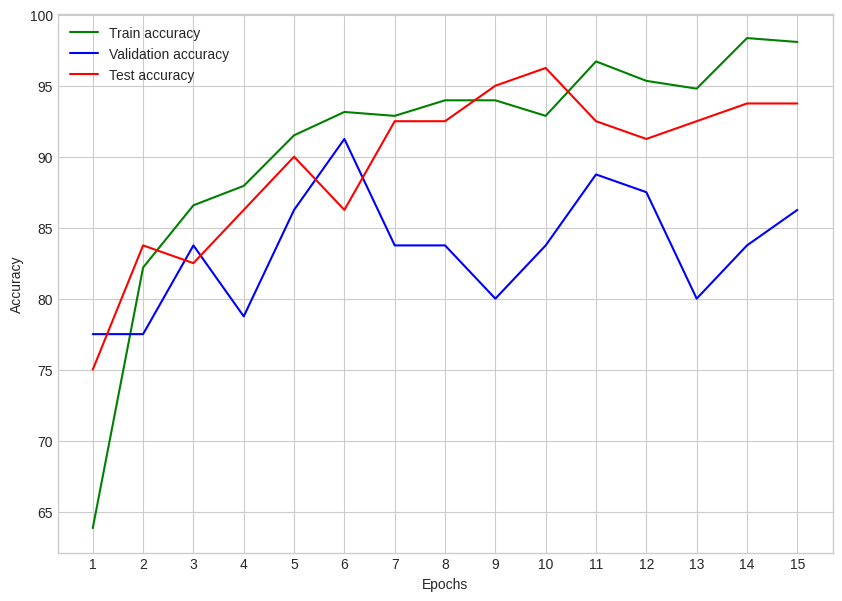

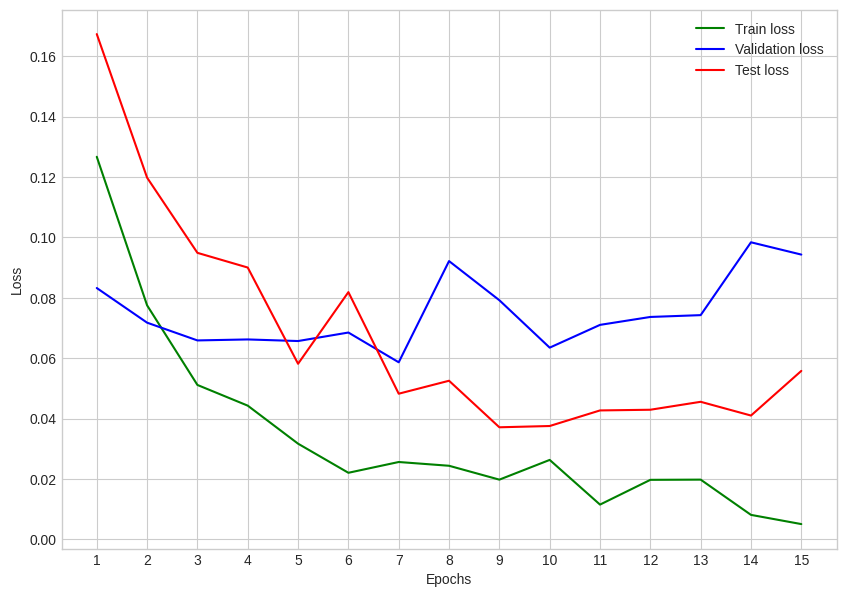

In [10]:
# define container lists to store losses and accuracies
train_loss, train_acc = [], []
valid_loss, valid_acc = [], []
test_loss, test_acc = [], []

# run training and validation methods in epoch
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_epoch_loss, train_epoch_acc = train(model, optimizer, criterion, train_loader)
    valid_epoch_loss, valid_epoch_acc = validate(model, criterion, valid_loader)
    test_epoch_loss, test_epoch_acc = validate(model, criterion, test_loader)
    
    # store the results in the container
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_loss.append(valid_epoch_loss)
    valid_acc.append(valid_epoch_acc)
    test_loss.append(test_epoch_loss)
    test_acc.append(test_epoch_acc)
    
    # print the results per epoch
    print(f"Training loss: {train_epoch_loss:.4f}, Training accuracy: {train_epoch_acc:.2f}%")
    print(f"Validation loss: {valid_epoch_loss:.4f}, Validation accuracy: {valid_epoch_acc:.2f}%")
    print(f"Test loss: {test_epoch_loss:.4f}, Test accuracy: {test_epoch_acc:.2f}%\n")

# save the trained model and weights
save_model(epochs=epochs, model=model,
           optimizer=optimizer, criterion=criterion)

# save the loss and accuracy plots
save_plot(train_acc= train_acc, train_loss=train_loss, 
          valid_acc=valid_acc, valid_loss=valid_loss,
          test_acc=test_acc, test_loss=test_loss)

# print that the training is done
print(f"TRAINING COMPLETE")

# TODO: check the test image with trained model
# TODO: check the test image with loaded model

In [51]:
## check the test image with the trained model
# first define an ImageFolder dataset 
train_dataset = datasets.ImageFolder(root='data/train')

# retrieve the class-to-index mapping
print(train_dataset.class_to_idx)

# list all class labels
labels = train_dataset.classes
print(labels)
num_classes = len(labels)

# define directory and file path based on the input
label = random.choice(labels)

dir = 'data/test'
dir_label = os.path.join(dir, label)
file_name = pick_random_file(dir_label)
file_path = os.path.join(dir_label, file_name)

{'down': 0, 'fist': 1, 'left': 2, 'right': 3, 'up': 4}
['down', 'fist', 'left', 'right', 'up']


In [52]:
# read the image using cv2
image = cv2.imread(file_path)
orig_image = image.copy()

# get the ground truth label
true_label = file_path.split('/')[-2]

print(f"True label: {true_label}")

# define a data tranformer to preprocess test image
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((360, 640)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# convert the format from BGR (cv2) to RGB (pytorch)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# apply the preprocess transformer to the image
image_tensor = transform(image)
print(image_tensor.shape)

# add batch dimension since the model expects a batch of image data
# ref: https://pytorch.org/docs/main/generated/torch.unsqueeze.html
image_tensor = image_tensor.unsqueeze(0).to(device)
print(image_tensor.shape)

# make an inference using the model
with torch.no_grad():
    outputs = model(image_tensor)
    _, predictions = torch.max(outputs, 1)
    pred_label = labels[predictions.item()]
    print(f"Predicted label: {true_label}")

# display true label over the image
cv2.putText(orig_image, 
    f"True: {true_label}",
    (10, 25),
    cv2.FONT_HERSHEY_SIMPLEX, 
    0.6, (50, 255, 50), 2, cv2.LINE_AA
)

# display predicted label over the image
cv2.putText(orig_image, 
    f"Pred: {pred_label}",
    (10, 55),
    cv2.FONT_HERSHEY_SIMPLEX, 
    0.6, (50, 50, 255), 2, cv2.LINE_AA
)

# show the result
print(f"True label: {true_label}, Predicted label: {pred_label}")
cv2.imshow('Result', orig_image)
key = cv2.waitKey(0)
cv2.destroyAllWindows()

True label: down
torch.Size([3, 360, 640])
torch.Size([1, 3, 360, 640])
Predicted label: down
True label: down, Predicted label: down


In [53]:
## check the test image with the loaded model
# instantiate the model and load the trained weights
model_loaded = CNN(num_classes).to(device)
state = torch.load('results/model.pth', map_location=device)
# ref: https://pytorch.org/docs/stable/generated/torch.load.html
model_loaded.load_state_dict(state['model_state_dict'])

# set the model to evaluation mode for inference
model_loaded.eval()

/tmp/ipykernel_26810/3870668694.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('results/model.pth', map_location=device)


CNN(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout_conv): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=112640, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
  (dropout_fc): Dropout(p=0.5, inplace=False)
)

In [54]:
# read the image using cv2
image = cv2.imread(file_path)
orig_image = image.copy()

# get the ground truth label
true_label = file_path.split('/')[-2]

print(f"True label: {true_label}")

# define a data tranformer to preprocess test image
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((360, 640)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# convert the format from BGR (cv2) to RGB (pytorch)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# apply the preprocess transformer to the image
image_tensor = transform(image)
print(image_tensor.shape)

# add batch dimension since the model expects a batch of image data
# ref: https://pytorch.org/docs/main/generated/torch.unsqueeze.html
image_tensor = image_tensor.unsqueeze(0).to(device)
print(image_tensor.shape)

# make an inference using the model
with torch.no_grad():
    outputs = model_loaded(image_tensor)
    _, predictions = torch.max(outputs, 1)
    pred_label = labels[predictions.item()]
    print(f"Predicted label: {true_label}")

# display true label over the image
cv2.putText(orig_image, 
    f"True: {true_label}",
    (10, 25),
    cv2.FONT_HERSHEY_SIMPLEX, 
    0.6, (50, 255, 50), 2, cv2.LINE_AA
)

# display predicted label over the image
cv2.putText(orig_image, 
    f"Pred: {pred_label}",
    (10, 55),
    cv2.FONT_HERSHEY_SIMPLEX, 
    0.6, (50, 50, 255), 2, cv2.LINE_AA
)

# show the result
print(f"True label: {true_label}, Predicted label: {pred_label}")
cv2.imshow('Result', orig_image)
key = cv2.waitKey(0)
cv2.destroyAllWindows()

True label: down
torch.Size([3, 360, 640])
torch.Size([1, 3, 360, 640])
Predicted label: down
True label: down, Predicted label: down
